## Pytorch Custom dataset

In [71]:
import torch                            # Core pytorch for tensor operator
import torch.nn as nn                   # Neural network module (layers, loss_function,..)
import torch.optim as optim             # optimization algorithms (SDG, RMSprop, Adam,...)
import torch.nn.functional as F         # Functional operations (activations, pooling,..)
import torch.utils.data as data         # Dataset handling and batching

import torchvision                                  # Computer vision utilities and pre-trained models
from torchvision import transforms                  # Image processing and augmentation
from torchvision import datasets                    # Image processing and augmentation
from torchvision.datasets import CIFAR100           # common CV datasets
from torchvision.models import resnet50             # Pre-trained model supported in PyTorch
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0


import matplotlib.pyplot as plt
from torchinfo import summary

# Check torch version
f"Torch version: {torch.__version__}", "^",\
f"Torchvision version: {torchvision.__version__}"

('Torch version: 2.5.1+cu121', '^', 'Torchvision version: 0.20.1+cu121')

### *Check if CUDA is available and set device*

In [ ]:
import torch.version 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device name: {torch.cuda.get_device_name()}")
print(f"Using device: {device}")
print(f"Cuda version: {torch.version.cuda}")

: 

: 

### *Get dataset (Food101)*

In [73]:
import requests
import zipfile
from pathlib import Path

# Setup path to Data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        dataset_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        request = requests.get(dataset_url)
        print("Downloading pizza, steak, sushi data...")
        f.write(requests.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)



data/pizza_steak_sushi directory exists.


## Data preparation

In [74]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 1 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


### *Setup training and testing path*

In [75]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir 

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### *Visualize an image*

Random image path: data/pizza_steak_sushi/train/pizza/2026009.jpg
Image class: pizza
Image height: 512
Image width: 512


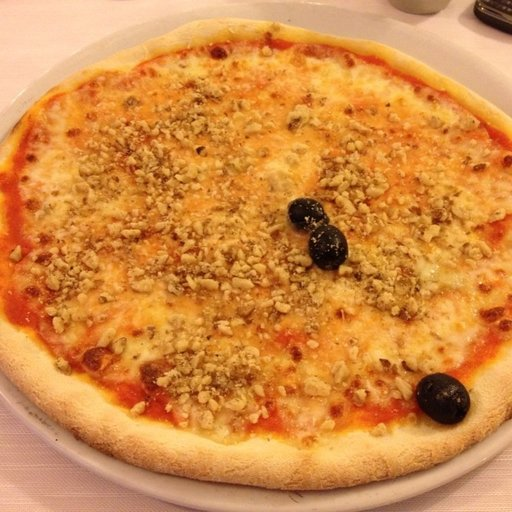

In [76]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))                # Get all the image paths (jpg included)
random_image_path = random.choice(image_path_list)                  # Chose a random image
image_class = random_image_path.parent.stem                         # Get the image class name (parent dir folder name)
img = Image.open(random_image_path)                                 # Open Image

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## Transforming data

In [77]:
# transform for our image
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),            # Resize image to 64x64
    transforms.RandomHorizontalFlip(p=0.5),     # Flip the image randomly on the horizontal
    transforms.ToTensor()                       # turn image into Torch Tensor
])



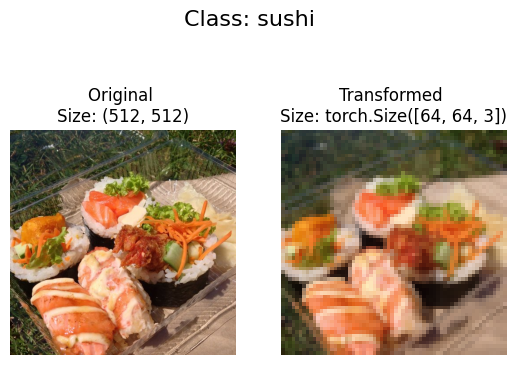

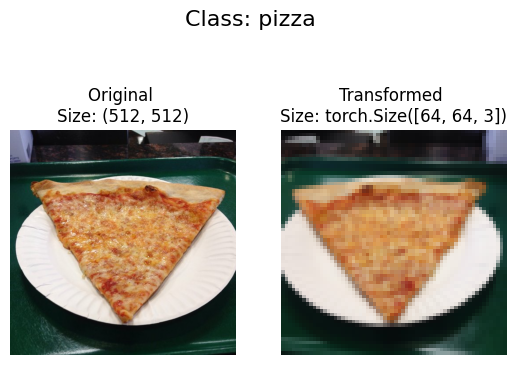

In [78]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=2)

## Load image 

### *ImageFolder*

In [79]:
train_data = datasets.ImageFolder(root=train_dir,               # target folder of images
                                  transform=data_transform,     # transform function performs on data
                                  target_transform=None,)       # transform to perform on labels (if needed)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data: \n{train_data}\n\nTest data: :\n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Test data: :
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [80]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [81]:
len(train_data), len(test_data)

(225, 75)

### *Detect image* 

In [82]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n{img}")
print(f"\nImage shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")

Image tensor: 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, heights, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_chanels]


Text(0.5, 1.0, 'pizza')

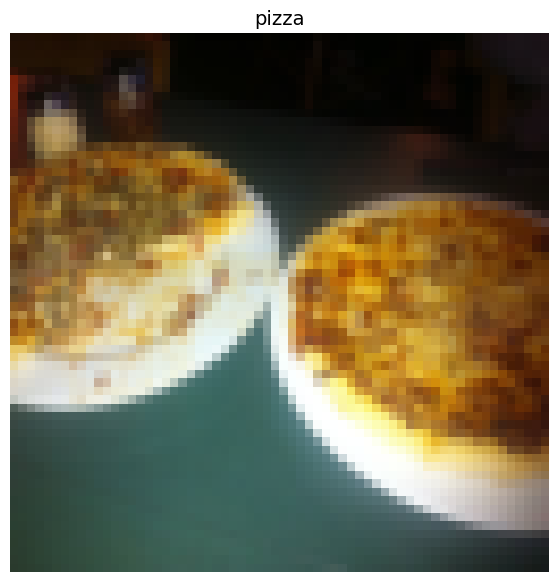

In [83]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, heights, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_chanels]")

plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(train_data.classes[label], fontsize=14)

### *Turn Image into Dataloader*

In [84]:
import os

train_dataloader = data.DataLoader(dataset=train_data,              
                                   batch_size=1,                        # How many sample per batch?
                                   num_workers=os.cpu_count(),          # How many subprocesses to use for data loading (no. cpu cores)
                                   shuffle=True)                        # Shuffle the data

test_dataloader = data.DataLoader(dataset=test_data,
                                  batch_size=1,
                                  num_workers=os.cpu_count(),
                                  shuffle=False)                        # No need to shuffle the testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x796d8800fd60>,
 <torch.utils.data.dataloader.DataLoader at 0x796db78cdd20>)

In [85]:
img, label = next(iter(train_dataloader))

print(f"Image shape; {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")    

Image shape; torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Custom load Image

### *Helper function to get class name*

In [86]:
import os
import pathlib 
from PIL import Image
from typing import Tuple, Dict, List

# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### *Custom dataset*

In [87]:
class ImageFolderCustom(data.Dataset):                  # 1. Subclass torch.utils.data.Dataset
    
    def __init__(self, targ_dir: str, transform=None) -> None:          # 2. Initialize with a targ_dir and transform (optional) parameter
        
        # 3. Create class attributes
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index: int) -> Image.Image:                    # 4. Make function to load images
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    def __len__(self) -> int:                                           # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:          # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        if self.transform:                                          # Transform if necessary
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
        


In [88]:

# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [89]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x796db78cf040>,
 <__main__.ImageFolderCustom at 0x796db78cc790>)

In [90]:
len(train_data_custom), len(test_data_custom)


(225, 75)

In [91]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [92]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset (simple check)
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [93]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

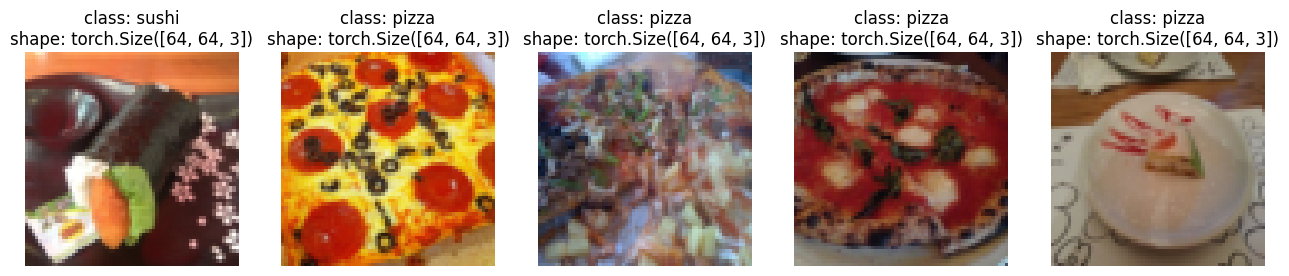

In [94]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=train_data_custom.classes,
                      seed=None)

### *Turn Custom Image into DataLoader*

In [95]:
train_dataloader_custom = data.DataLoader(dataset=train_data_custom,            # use custom data created by ImageFolderCustom
                                          batch_size=16,                         # How many samples per batch?
                                          num_workers=8,                        # how many subprocesses to use for data loading
                                          shuffle=True)                 

test_dataloader_custom = data.DataLoader(dataset=test_data_custom,
                                         batch_size=16,
                                         num_workers=0,
                                         shuffle=False)                         # No need to shuffle test set

train_dataloader_custom, test_dataloader_custom

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(<torch.utils.data.dataloader.DataLoader at 0x796db7460c70>,
 <torch.utils.data.dataloader.DataLoader at 0x796db74605e0>)

In [96]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


## Data Augmentation

In [97]:
train_transforms_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()                                       # To Tensor() last to get everythings between 0 & 1
])

# Don't need to perform augmentation on test data




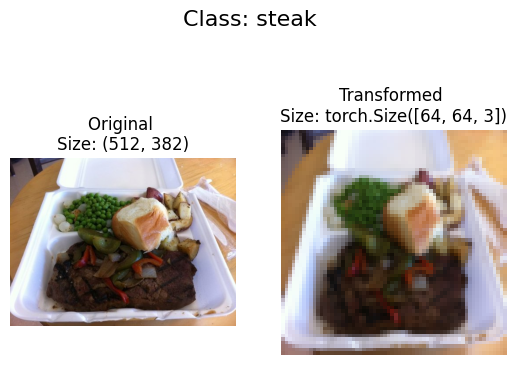

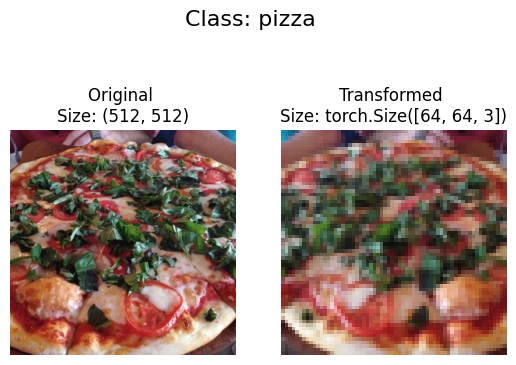

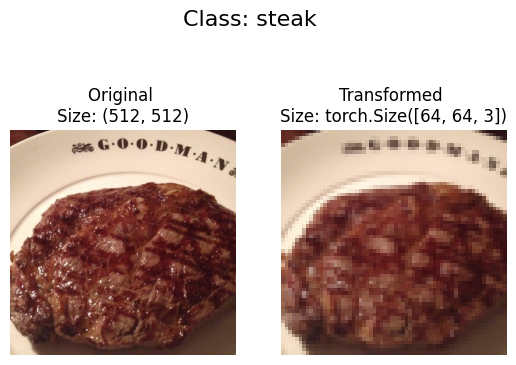

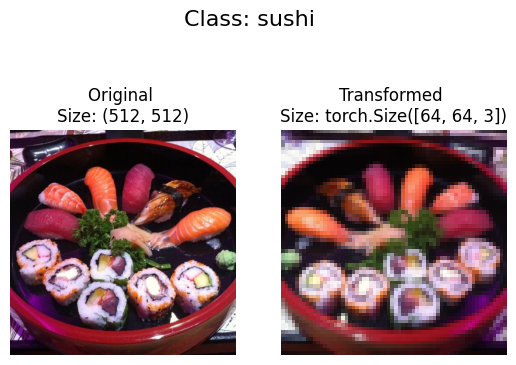

In [98]:
# Get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random image
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transforms,
                        n=4,
                        seed=None)


## Model 0 : TinyVGG without Augmentation

### *Custom transform image*

In [99]:
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [100]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating Dataloader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dataloader_simple = data.DataLoader(train_data_simple,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=True)

test_dataloader_simple = data.DataLoader(test_data_simple,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple


Creating Dataloader's with batch size 32 and 4 workers.


(<torch.utils.data.dataloader.DataLoader at 0x796dd4306050>,
 <torch.utils.data.dataloader.DataLoader at 0x796db7940640>)

### *TinyVGG model*

In [101]:
class TinyVGG(nn.Module):
    """Model architecture copied from TinyVGG explainer"""
    def __init__(self, input_shape:int, hidden_units=int, output_shape=int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,                        # How big  is the square that's going over image?
                      stride=1,
                      padding=1),                           # options = "valid" (no padding)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)                  # default stride value is the same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units,hidden_units, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )


    def forward(self, x:torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # return self.classifier(self.conv_block2(self.conv_block_1(x)))        # Leverage the benefits of operator fusion
        return self.classifier(x)
    
torch.manual_seed(16)
model_tinyVGG_0 = TinyVGG(input_shape=3, 
                          hidden_units=10,
                          output_shape=len(train_data.classes)).to(device)

model_tinyVGG_0
    
        

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### *Single image testing*

In [102]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")


# perform forward pass on single image
model_tinyVGG_0.eval()
with torch.inference_mode():
    pred = model_tinyVGG_0(img_single.to(device))

# Print out what's happening and convert model logits -> pred probs -> pred_label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1))}\n")
print(f"Actual Label:\n{label_single}\n")
print(f"Class name: {train_data.classes[label_single]}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0371, -0.0600,  0.0087]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3473, 0.3151, 0.3376]], device='cuda:0')

Output prediction label:
0

Actual Label:
0

Class name: pizza


### *Model summary*

In [103]:
summary(model_tinyVGG_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## Train & Test Loop functions

### *Train step*

In [104]:
def train_step(model: nn.Module,
               dataloader: data.DataLoader,
               criterion:nn.Module,
               optimizer:optim.Optimizer):
    """"""
    model.train()                                      #! Put model in train mode
    train_loss, train_acc = 0,0                        #! Initiate train loss and train acc val
    
    for batch, (X, y) in enumerate(dataloader):                 #! Loop through dataloader , data batches

        X , y = X.to(device), y.to(device)                  #! Send data to the target device
        y_pred = model(X)                                   #! 1. Forward pass
        loss = criterion(y_pred, y)                         #! 2. Calculate loss
        train_loss += loss.item()                           #!      Accumulate loss
        optimizer.zero_grad()                               #! 3. Optimizer zero gradient
        loss.backward()                                     #! 4. Loss backward
        optimizer.step()                                    #! 5.Optimizer step

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)            #? Calculate and accumulate accuracy 
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)                   #? metrics across all batches

    train_loss = train_loss / len(dataloader)                               # Adjust metrics to get average loss
    train_acc = train_acc / len(dataloader)                                 # and accuracy per batch
    return train_loss, train_acc

### *Test step*

In [105]:
def test_step(model:nn.Module,
              dataloader:data.DataLoader,
              criterion:nn.Module):
    """"""
    model.eval()                                # Put model in eval mode
    test_loss, test_acc = 0,0                   #  Set up test loss and test accuracy values

    with torch.inference_mode():                                    #! Turn on inferences context manager
        for batch, (X, y) in enumerate(dataloader):                 #! Loop through dataloader batches

            X, y = X.to(device), y.to(device)                           #! Send data to target device
            test_pred_logits = model(X)                                 #! 1. Forward pass
            loss = criterion(test_pred_logits, y)                       #! 2. Calculate and accumulate loss
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)                               #? Calculate and accumulate accuracy
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)                                                 #? Adjust metrics to get average loss
    test_acc = test_acc / len(dataloader)                                                   #? and accuracy per batch
    return test_loss, test_acc


### *Train loop*

In [106]:
from tqdm.autonotebook import tqdm

def train(model:nn.Module,
          train_dataloader: data.DataLoader,
          test_dataloader: data.DataLoader,
          optimizer:optim.Optimizer,
          criterion:nn.Module=nn.CrossEntropyLoss(),
          epochs:int=5):
    
    results = {"train_loss":[],                                              #! Create empty results dictionary
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}
    
    for epoch in tqdm(range(epochs)):                                        #! Loop through all training and testing steps for number of epoch

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           criterion=criterion,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        criterion=criterion)
        
        print(                                                              #! Print out what's happening
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
        )

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)             # Update result dictionary
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)                 # Ensure all data is moved to CPU and converted to float for storage
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)                 #
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    return results


## Train and evaluate Model

### *TinyVGG model*

In [107]:
torch.manual_seed(16)
torch.cuda.manual_seed(16)

EPOCHS = 10

model_tinyVGG_0 = TinyVGG(input_shape=3, 
                          hidden_units=10,
                          output_shape=len(train_data.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_tinyVGG_0.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_tinyVGG_0_result = train(model=model_tinyVGG_0,
                               train_dataloader=train_dataloader_simple,
                               test_dataloader=test_dataloader_simple,
                               optimizer=optimizer,
                               criterion=criterion,
                               epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1096 | train_acc: 0.2852 | test_loss: 1.1099 | test_acc: 0.1979 | 
Epoch: 2 | train_loss: 1.0911 | train_acc: 0.3516 | test_loss: 1.0780 | test_acc: 0.5625 | 
Epoch: 3 | train_loss: 1.0928 | train_acc: 0.4180 | test_loss: 1.0801 | test_acc: 0.4527 | 
Epoch: 4 | train_loss: 1.0627 | train_acc: 0.5781 | test_loss: 1.0814 | test_acc: 0.3314 | 
Epoch: 5 | train_loss: 0.9446 | train_acc: 0.5273 | test_loss: 1.1441 | test_acc: 0.2292 | 
Epoch: 6 | train_loss: 1.0129 | train_acc: 0.4297 | test_loss: 1.0543 | test_acc: 0.3930 | 
Epoch: 7 | train_loss: 0.9929 | train_acc: 0.5430 | test_loss: 1.0188 | test_acc: 0.4744 | 
Epoch: 8 | train_loss: 0.9074 | train_acc: 0.5312 | test_loss: 0.9728 | test_acc: 0.5038 | 
Epoch: 9 | train_loss: 0.8465 | train_acc: 0.6680 | test_loss: 0.9988 | test_acc: 0.3939 | 
Epoch: 10 | train_loss: 0.7705 | train_acc: 0.6680 | test_loss: 1.0495 | test_acc: 0.4848 | 
Total training time: 8.861 seconds


In [108]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

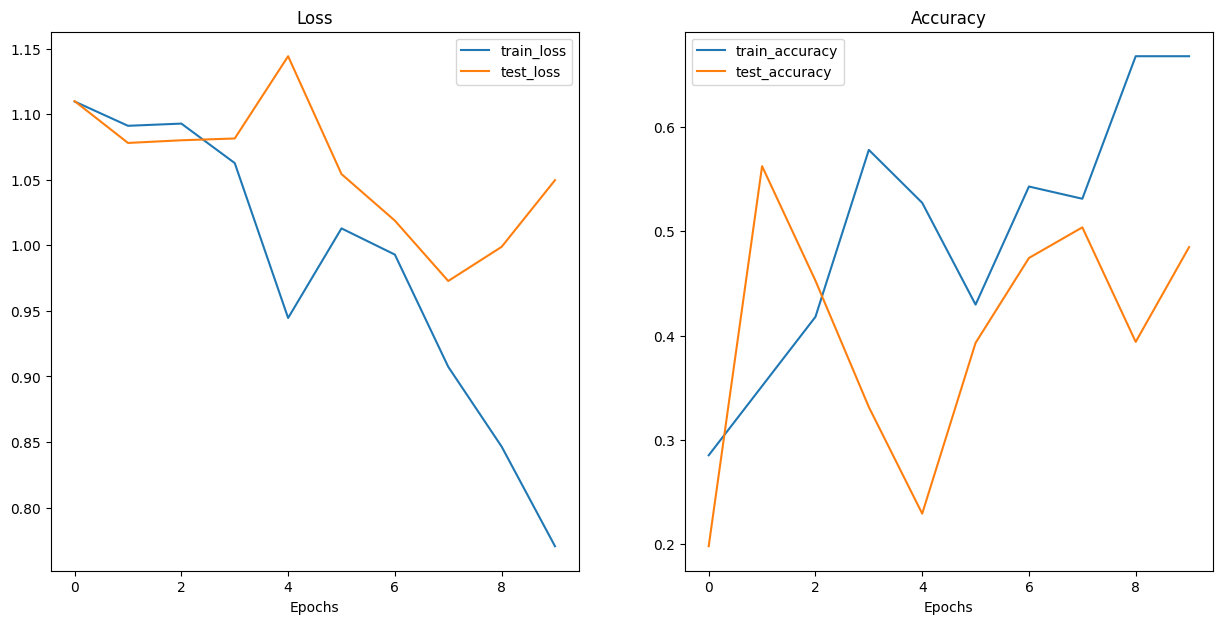

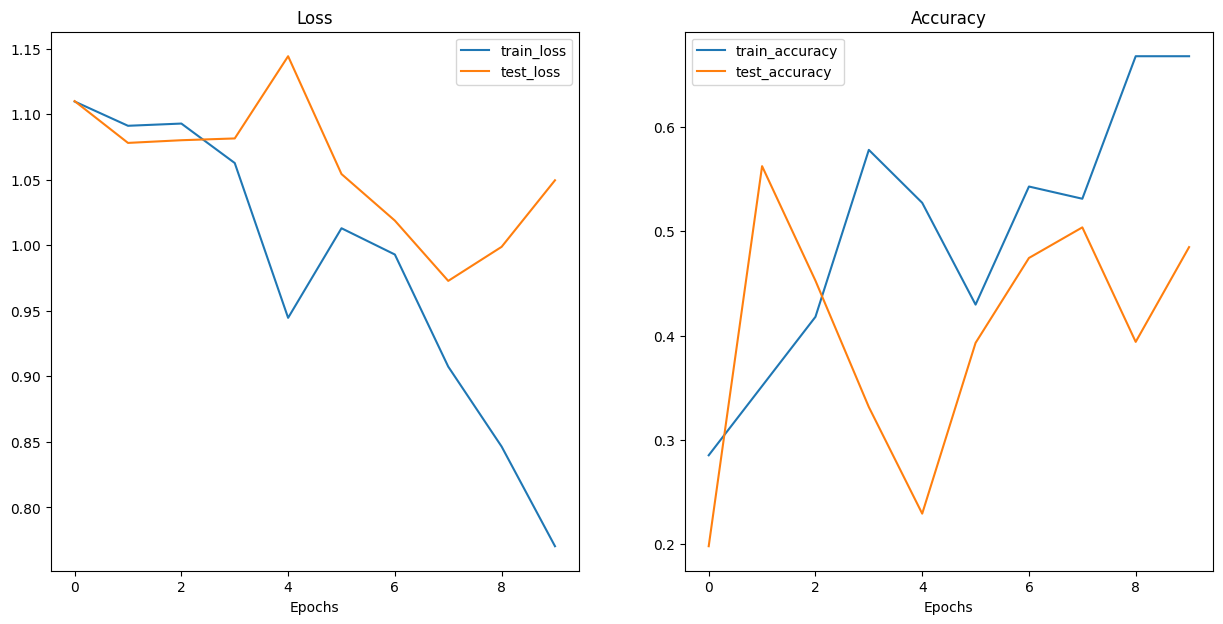

In [ ]:
plot_loss_curves(model_tinyVGG_0_result)

### *TinyVGG model with data augment*

In [ ]:
# Copied that
train_transforms_trivial = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()                                       # To Tensor() last to get everythings between 0 & 1
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Turn image folders into Datasets all over again
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transforms_trivial)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = data.DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = data.DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a9a107ca1b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a99d03cf440>)

In [ ]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_tinyVGG_1_augment = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_tinyVGG_1_augment

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_tinyVGG_1_augment.parameters(), lr=0.001)

from timeit import default_timer as timer 
start_time = timer()

model_tinyVGG_1_augment_results = train(model=model_tinyVGG_1_augment, 
                                        train_dataloader=train_dataloader_augmented,
                                        test_dataloader=test_dataloader_simple,
                                        optimizer=optimizer,
                                        criterion=criterion, 
                                        epochs=EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:01<00:12,  1.42s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604 | 


 20%|██        | 2/10 [00:02<00:09,  1.25s/it]

Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1384 | test_acc: 0.2604 | 


 30%|███       | 3/10 [00:03<00:09,  1.32s/it]

Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604 | 


 40%|████      | 4/10 [00:05<00:07,  1.26s/it]

Epoch: 4 | train_loss: 1.1287 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604 | 


 50%|█████     | 5/10 [00:06<00:06,  1.26s/it]

Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1475 | test_acc: 0.2604 | 


 60%|██████    | 6/10 [00:07<00:05,  1.28s/it]

Epoch: 6 | train_loss: 1.0968 | train_acc: 0.3047 | test_loss: 1.1478 | test_acc: 0.2604 | 


 70%|███████   | 7/10 [00:08<00:03,  1.28s/it]

Epoch: 7 | train_loss: 1.0928 | train_acc: 0.4414 | test_loss: 1.1500 | test_acc: 0.1979 | 


 80%|████████  | 8/10 [00:10<00:02,  1.28s/it]

Epoch: 8 | train_loss: 1.1005 | train_acc: 0.2930 | test_loss: 1.1554 | test_acc: 0.1979 | 


 90%|█████████ | 9/10 [00:11<00:01,  1.11s/it]

Epoch: 9 | train_loss: 1.1206 | train_acc: 0.2930 | test_loss: 1.1453 | test_acc: 0.2188 | 


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Epoch: 10 | train_loss: 1.0944 | train_acc: 0.3281 | test_loss: 1.1009 | test_acc: 0.2907 | 
Total training time: 11.695 seconds


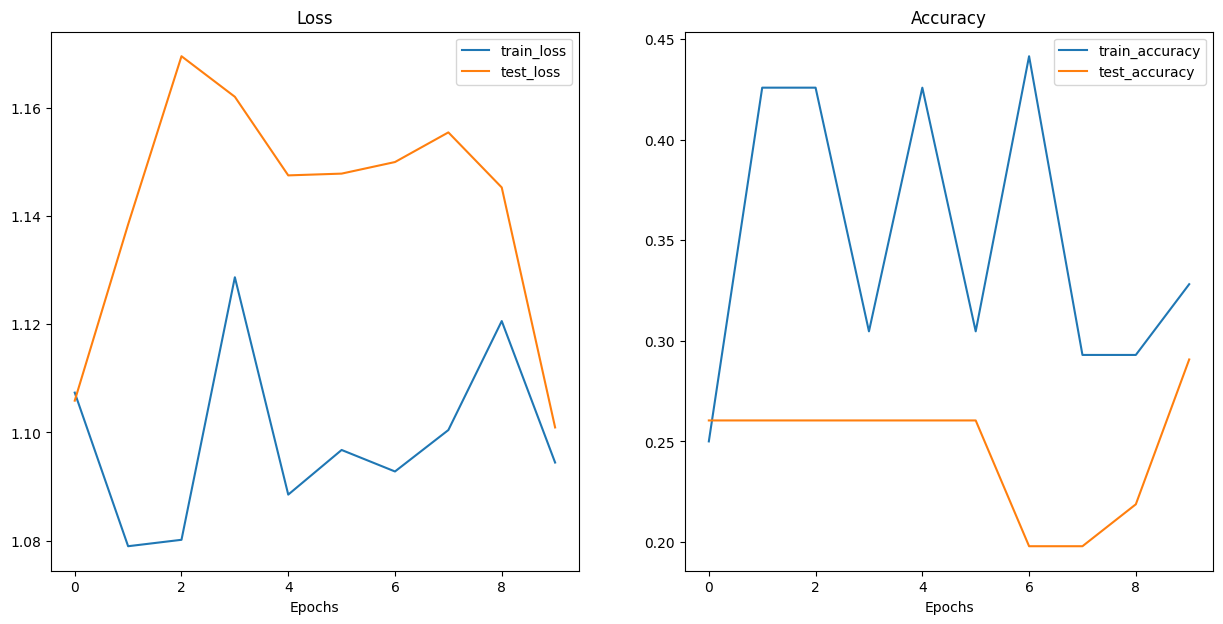

In [ ]:
plot_loss_curves(model_tinyVGG_1_augment_results)

### *Compare models*

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_tinyVGG_0_result)
model_1_df = pd.DataFrame(model_tinyVGG_1_augment_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.109598   0.285156   1.109886  0.197917
1    1.091078   0.351562   1.078019  0.562500
2    1.092761   0.417969   1.080050  0.452652
3    1.062661   0.578125   1.081410  0.331439
4    0.944585   0.527344   1.144119  0.229167
5    1.012885   0.429688   1.054276  0.392992
6    0.992905   0.542969   1.018803  0.474432
7    0.907381   0.531250   0.972781  0.503788
8    0.846565   0.667969   0.998792  0.393939
9    0.770602   0.667969   1.049628  0.484848

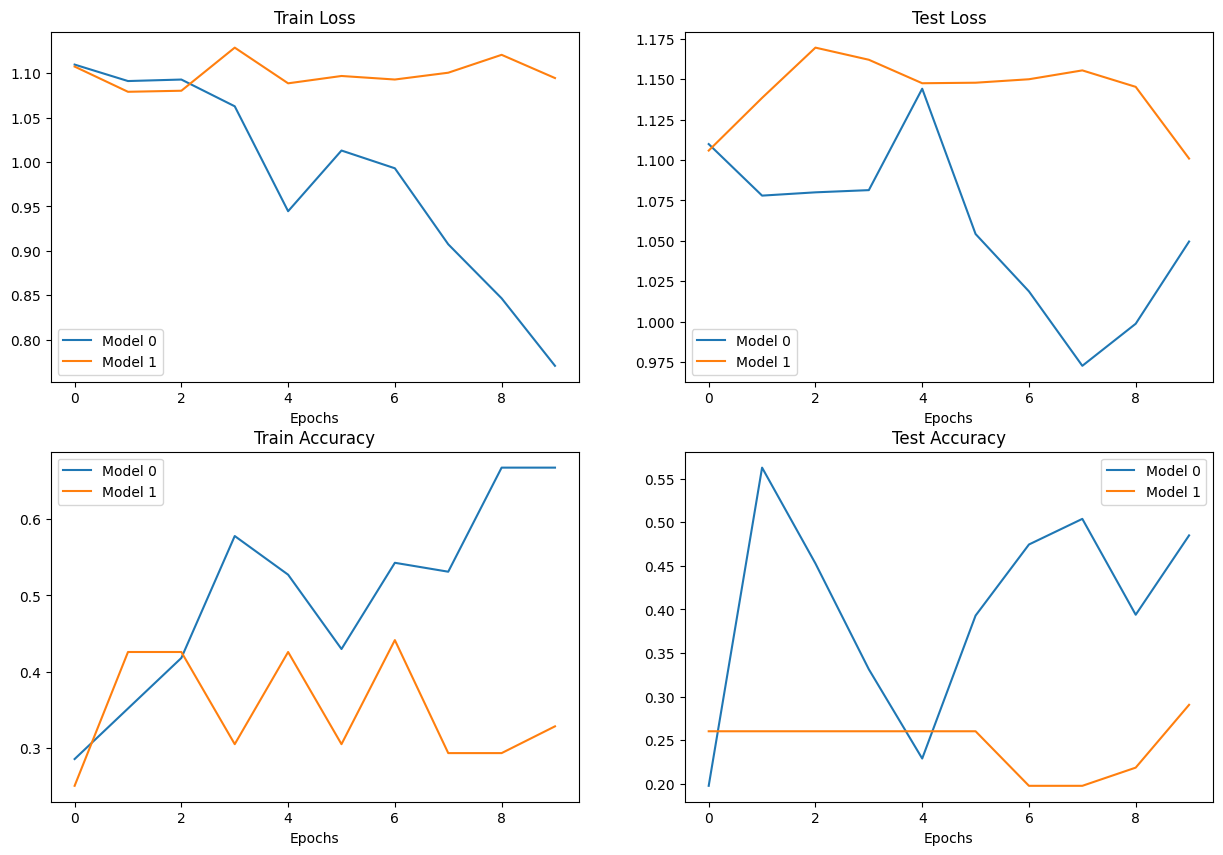

In [ ]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Inference

### *Load any image*

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


### *Convert it into tensor*

In [ ]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")


Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

### *Convert datatype to fit model*

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### *Plot image*

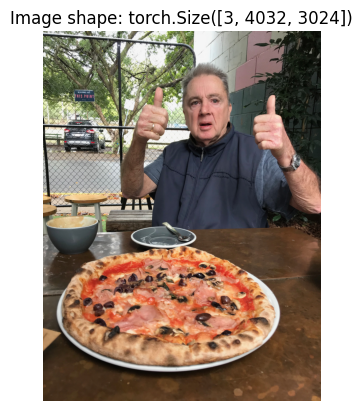

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

### *Resize image pipeline*

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


### *Predict image with batch size=1*

In [ ]:
model_tinyVGG_1_augment.eval()
with torch.inference_mode():

    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueeze custom image transformed shape: {custom_image_transformed_with_batch_size.shape}")

    custom_image_pred = model_tinyVGG_1_augment(custom_image_transformed_with_batch_size.to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueeze custom image transformed shape: torch.Size([1, 3, 64, 64])


### *Logits form*

In [ ]:
custom_image_pred

tensor([[ 0.0043,  0.0020, -0.0266]], device='cuda:0')

### *logits -> pred prob-> pred labels.*

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.0043,  0.0020, -0.0266]], device='cuda:0')
Prediction probabilities: tensor([[0.3370, 0.3362, 0.3268]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [ ]:
# Find the predicted label
custom_image_pred_class = train_data.classes[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

# How the hell was that?

'pizza'

### *Inferences pipeline*

Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:

- Takes in a target image path and converts to the right datatype for our model (torch.float32).

- Makes sure the target image pixel values are in the range [0, 1].

- Transforms the target image if necessary.

- Makes sure the model is on the target device.

- Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).

- Converts the model's output logits to prediction probabilities.

- Converts the prediction probabilities to prediction labels.

- Plots the target image alongside the model prediction and prediction probability.



In [ ]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)               # 1. Load in image and convert the tensor values to float32
    target_image = target_image / 255.                                                          # 2. Divide the image pixel values by 255 to get them between [0, 1]
    
    if transform:                                                                               # 3. Transform if necessary
        target_image = transform(target_image)
    
    model.to(device)                                                                            # 4. Make sure the model is on the target device
    
    model.eval()                                                                                # 5. Turn on model evaluation mode and inference mode
    with torch.inference_mode():
        
        target_image = target_image.unsqueeze(dim=0)                                            # Add an extra dimension to the image
        target_image_pred = model(target_image.to(device))                                      # Make a prediction on image with an extra dimension and send it to the target device
        
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)                           # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)                      # 7. Convert prediction probabilities -> prediction labels
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

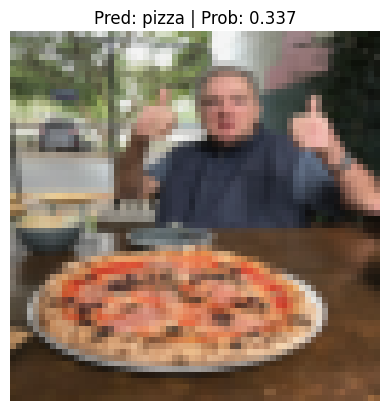

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_tinyVGG_1_augment,
                    image_path=custom_image_path,
                    class_names=train_data.classes,
                    transform=custom_image_transform,
                    device=device)

## Modular

### *Get data*

In [ ]:
%%writefile modular/get_data.py

import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Overwriting modular/get_data.py


### *Dataloader*

In [ ]:
%%writefile modular/data_setup.py

"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Overwriting modular/data_setup.py


### *Making model*

In [ ]:
%%writefile modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn 

class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=0),  
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from? 
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


Overwriting modular/model_builder.py


### *Training and testing*

In [ ]:
%%writefile modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results


Overwriting modular/engine.py


### *Save model*

In [ ]:
%%writefile modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Overwriting modular/utils.py


### *Training*

In [ ]:
%%writefile modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Overwriting modular/train.py


## Transfer Learning

### *Get a set of pre-trained model weights*

In [ ]:
weights = EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

### *Get the transforms that associated with this weights*

In [ ]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### *Set up model with pre-trained weights*

In [ ]:
transferred_model = efficientnet_b0(weights=weights)

### *Sent model to target device*

In [ ]:
transferred_model = transferred_model.to(device)

### *Model Summary*

In [ ]:
summary(transferred_model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=transferred_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### *Freeze all base layers*

In [ ]:
for param in transferred_model.features.parameters():
    param.requires_grad = False

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=transferred_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### *Model classifier layer*

In [ ]:
transferred_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### *Update model classifier layer*

In [ ]:
torch.manual_seed(16)
torch.cuda.manual_seed(16)

output_shape = len(train_data.classes)

# Recreate the classifier layer and seed it to the target device
transferred_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
transferred_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

### *Model Summary*

In [ ]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(transferred_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### *Train model*

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=transferred_model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       epochs=5)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:05<00:21,  5.28s/it]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3600 | test_loss: 2.0227 | test_acc: 0.3067 | 


 40%|████      | 2/5 [00:10<00:15,  5.19s/it]

Epoch: 2 | train_loss: 1.0967 | train_acc: 0.3244 | test_loss: 1.8308 | test_acc: 0.2667 | 


 60%|██████    | 3/5 [00:13<00:08,  4.46s/it]

Epoch: 3 | train_loss: 1.0957 | train_acc: 0.3511 | test_loss: 1.7232 | test_acc: 0.3333 | 


 80%|████████  | 4/5 [00:17<00:04,  4.13s/it]

Epoch: 4 | train_loss: 1.1024 | train_acc: 0.3244 | test_loss: 1.8104 | test_acc: 0.3200 | 


100%|██████████| 5/5 [00:21<00:00,  4.24s/it]

Epoch: 5 | train_loss: 1.0981 | train_acc: 0.3556 | test_loss: 2.1166 | test_acc: 0.2667 | 
[INFO] Total training time: 21.216 seconds


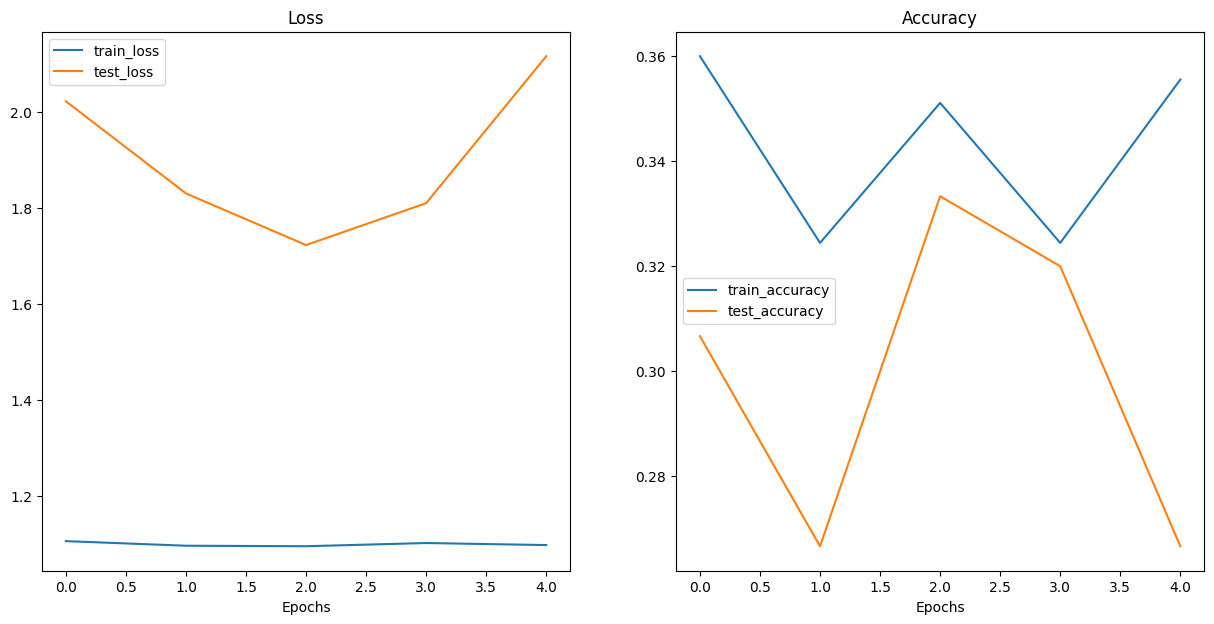

In [ ]:
plot_loss_curves(results)

### *Inference*

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);


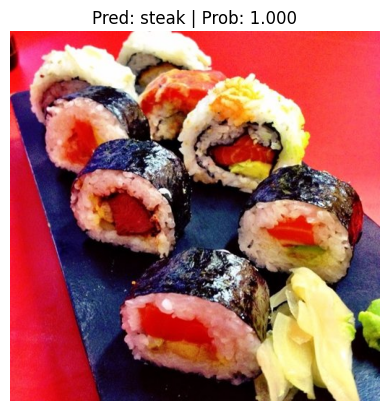

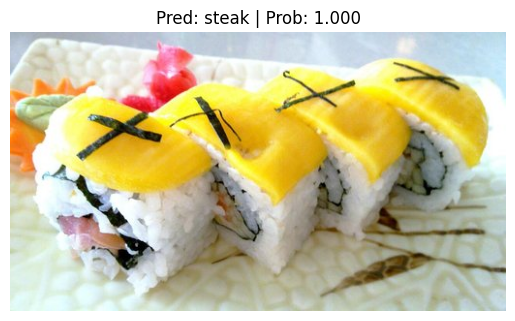

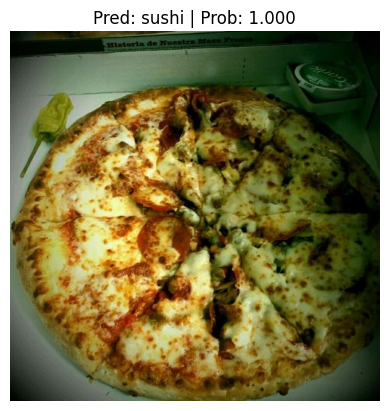

In [ ]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=transferred_model, 
                        image_path=image_path,
                        class_names=train_data.classes,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

data/04-pizza-dad.jpeg already exists, skipping download.


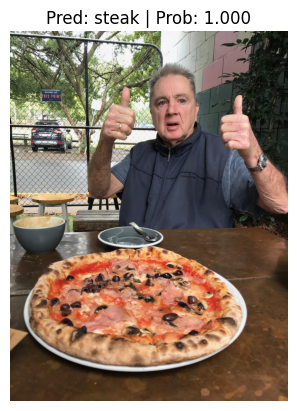

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=transferred_model,
                    image_path=custom_image_path,
                    class_names=train_data.classes)


## Experiment Tracking

### *Set up experiments*

In [ ]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

### *Training code*

In [ ]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

In [ ]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [ ]:

%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")


### 7.1 What kind of experiments should you run?

That's the million dollar question in machine learning.

Because there's really no limit to the experiments you can run.

Such a freedom is why machine learning is so exciting and terrifying at the same time.

This is where you'll have to put on your scientist coat and remember the machine learning practitioner's motto: experiment, experiment, experiment!

Every hyperparameter stands as a starting point for a different experiment:

- Change the number of epochs.
    
- Change the number of layers/hidden units.
    
- Change the amount of data.
    
- Change the learning rate.
    
- Try different kinds of data augmentation.
    
- Choose a different model architecture.

With practice and running many different experiments, you'll start to build an intuition of what might help your model.

I say might on purpose because there's no guarantee.

But generally, in light of The Bitter Lesson (I've mentioned this twice now because it's an important essay in the world of AI), generally the bigger your model (more learnable parameters) and the more data you have (more opportunities to learn), the better the performance.

However, when you're first approaching a machine learning problem: start small and if something works, scale it up.

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what doesn't work, in turn, the faster you can work out what does work.


### Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps:

- Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).

- Keep track of different experiment numbers (this is mostly for pretty print outs).

- Loop through the train_dataloaders dictionary items for each of the different training DataLoaders.

- Loop through the list of epoch numbers.

- Loop through the list of different model names.

- Create information print outs for the current running experiment (so we know what's happening).

- Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).

- Create a new loss function (torch.nn.CrossEntropyLoss()) and optimizer (torch.optim.Adam(params=model.parameters(), lr=0.001)) for each new experiment.

- Train the model with the modified train() function passing the appropriate details to the writer parameter.

- Save the trained model with an appropriate file name to file with save_model() from utils.py.


We can also use the %%time magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.